### 1. Import the libraries that we need


In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from keras.applications import mobilenet
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/
gdrive	sample_data


In [4]:
%cd /content/gdrive/My Drive/DL/Assignments/TL_Project

/content/gdrive/My Drive/DL/Assignments/TL_Project


### 2. Data preparation

In [6]:
train_path  = 'data/train'
valid_path  = 'data/valid'
test_path  = 'data/test'

In [7]:
train_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    train_path, target_size=(224,224), batch_size=30)
valid_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    valid_path, target_size=(224,224), batch_size=30)
test_batches = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input).flow_from_directory(
    test_path, target_size=(224,224), batch_size=30)

Found 202 images belonging to 2 classes.
Found 103 images belonging to 2 classes.
Found 451 images belonging to 2 classes.


### 3. Download VGGNet and create our new network

Showing samples of the train dataset

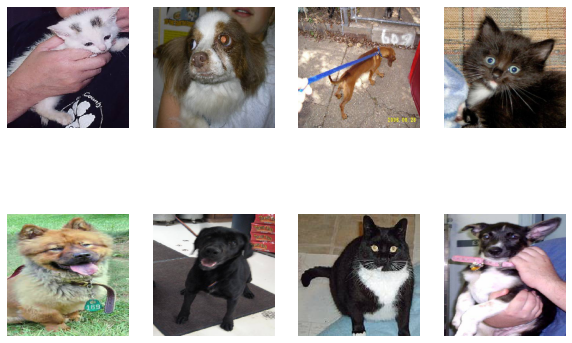

In [43]:
import cv2
from matplotlib import pyplot as plt

train_files, train_targets = load_dataset('data/train')
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 2
columns = 4
  
# reading images
for i in range(8):
  test_img_ = image.load_img(train_files[i], target_size=(224, 224))
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(test_img_)
  plt.axis('off')

In [8]:
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
base_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [18]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

# use “get_layer” method to save the last layer of the network
# save the output of the last layer to be the input of the next layer
last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten()(last_output)

# add 2 FC layers, each has 4096 units and relu activation 
x = Dense(64, activation='relu', name='FC_2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# add our new softmax layer with 3 hidden units
x = Dense(2, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
new_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
new_model.fit_generator(train_batches, steps_per_epoch=4,
                   validation_data=valid_batches, validation_steps=2, epochs=20, verbose=2)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
4/4 - 78s - loss: 0.9876 - accuracy: 0.5536 - val_loss: 1.6960 - val_accuracy: 0.7500
Epoch 2/20
4/4 - 61s - loss: 0.4172 - accuracy: 0.7946 - val_loss: 1.0131 - val_accuracy: 0.8000
Epoch 3/20
4/4 - 57s - loss: 0.2810 - accuracy: 0.8482 - val_loss: 0.6097 - val_accuracy: 0.8333
Epoch 4/20
4/4 - 57s - loss: 0.1332 - accuracy: 0.9375 - val_loss: 0.5088 - val_accuracy: 0.8833
Epoch 5/20
4/4 - 57s - loss: 0.1269 - accuracy: 0.9643 - val_loss: 0.3493 - val_accuracy: 0.9167
Epoch 6/20
4/4 - 56s - loss: 0.0532 - accuracy: 0.9821 - val_loss: 0.5499 - val_accuracy: 0.8833
Epoch 7/20
4/4 - 59s - loss: 0.0602 - accuracy: 0.9833 - val_loss: 0.3013 - val_accuracy: 0.9333
Epoch 8/20
4/4 - 56s - loss: 0.0236 - accuracy: 1.0000 - val_loss: 0.2251 - val_accuracy: 0.9500
Epoch 9/20
4/4 - 56s - loss: 0.0340 - accuracy: 0.9911 - val_loss: 0.2860 - val_accuracy: 0.9333
Epoch 10/20
4/4 - 56s - loss: 0.0403 - accuracy: 0.9821 - val_loss: 0.2308 - val_accuracy: 0.9333
Epoch 11/20
4/4 - 56s - loss:

In [13]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

In [14]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset('data/test')

In [15]:
from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|██████████| 451/451 [00:03<00:00, 118.55it/s]


In [16]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

15/15 [==============================] - 146s 10s/step - loss: 0.1462 - accuracy: 0.9490

Testing loss: 0.1462
Testing accuracy: 0.9490


In [17]:
# evaluate and print test accuracy
score = new_model.evaluate(test_tensors, test_targets)
print('\n', 'Test accuracy:', score[1])

15/15 [==============================] - 145s 10s/step - loss: 0.1462 - accuracy: 0.9490

 Test accuracy: 0.949002206325531


(224, 224, 3)
Cat Probabilty:  99.54990744590759 
Dog Probabilty:  0.45009516179561615


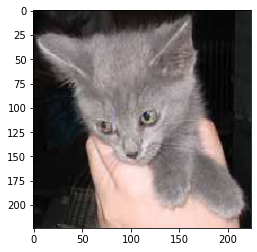

In [38]:
import matplotlib.pyplot as plt

test_img_ = image.load_img(test_files[5], target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
x = image.img_to_array(test_img_)
x1 = np.expand_dims(x, axis=0)
plt.imshow(test_img_)
print(x.shape)
pred = new_model.predict(x1)
print('Cat Probabilty: ',pred[0][0]*100,'\nDog Probabilty: ',pred[0][1]*100)